In [2]:
%pip install optuna
%pip install wandb
import optuna
import math
import torch
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import time
import similarity_measure
import wandb
%pip install plotly
%pip install "jupyterlab>=3" "ipywidgets>=7.6"
import plotly
torch.cuda.set_device(0)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
wandb.login()

True

In [6]:
from collections import namedtuple

Point = namedtuple('Point', ['x', 'y'])

In [7]:
# Taken from Team 1 - 2021
def read_flow(path:str):
    """
    Optical flow maps are saved as 3-channel uint16 PNG images: The first channel
    contains the u-component, the second channel the v-component and the third
    channel denotes if a valid ground truth optical flow value exists for that
    pixel (1 if true, 0 otherwise)
    """
    # cv2 flips the order of reading channels
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.double)
    
    # valid channel
    valid = img[:,:,0]
    
    # get flow vectors
    u_flow = (img[:,:,2] - 2**15)/64
    v_flow = (img[:,:,1] - 2**15)/64
    
    # remove invalid flow values
    u_flow[valid == 0] = 0
    v_flow[valid == 0] = 0
    
    # return image in correct order
    return np.dstack((u_flow, v_flow, valid))

# Taken from Team 1 - 2021
def get_metrics(gt_flow:np.ndarray, pred_flow:np.ndarray, mask:np.ndarray=None, th:int=3):
    """
    Calculate metrics from ground truth and predicted optical flow.
    The mask is usually the third channel of gt_flow
    
    Arguments:
        gt_flow,pred_flow are (H,W,3)
        th: motion_vector error greater than threshold is an erroneous pixel
        
    Returns:
     1. Mean Square Error in Non-occluded areas
     2. Percentage of Erroneous Pixels in Non-occluded areas
    """
    mask = gt_flow[:,:,2]  
    
    error = np.sqrt(np.sum((gt_flow[:,:,:2] - pred_flow[:,:,:2])**2, axis=-1))    
    msen = np.mean(error[mask != 0])
    pepn = 100 * np.sum(error[mask != 0] > th) / (mask != 0).sum()
    return msen, pepn

def get_metrics_v2(calculated_flow, ground_truth_flow, threshold):
    # Calculate error
    error = calculated_flow[:, :, :2] - ground_truth_flow[:, :, :2]

    # Calculate squared error
    squared_error = np.sum(error**2, axis=2)

    # Calculate magnitude of ground truth flow
    gt_magnitude = np.sqrt(np.sum(ground_truth_flow**2, axis=2))

    # Calculate MSEN
    msen = np.sqrt(np.mean(squared_error))

    # Identify non-occluded areas
    non_occluded_pixels = np.ones_like(gt_magnitude, dtype=bool)

    # Calculate PEPN
    pepn = np.sum(squared_error[non_occluded_pixels] > threshold) / np.sum(non_occluded_pixels)

    return msen, pepn

In [8]:
def plot_flow(flow, img, step):
    h, w = img.shape
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T
    lines = np.vstack([x, y, x - fx, y - fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    
    bgr = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    cv2.polylines(bgr, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(bgr, (x1, y1), 1, (0, 255, 0), -1)
    plt.imshow(bgr)
    plt.show()
    return bgr

In [9]:
def block_matching(img1, img2, block_size, search_area_size, step, similarity):
    h, w = img1.shape
    h_fact = h // block_size
    w_fact = w // block_size
    flow = np.zeros((h, w, 2), dtype=np.float16)

    for i in range(0, h_fact):
        for j in range(0, w_fact):
            template_start = Point(i * block_size, j * block_size)
            template_stop = Point(template_start.x + block_size, template_start.y + block_size)

            search_area_start = Point(max(0, template_start.x - search_area_size), \
                                      max(0, template_start.y - search_area_size))
            search_area_stop = Point(min(h, template_stop.x + search_area_size), \
                                     min(w, template_stop.y + search_area_size))

            match_start = find_match(img1[template_start.x:template_stop.x , template_start.y:template_stop.y], \
                                     img2[search_area_start.x:search_area_stop.x, search_area_start.y:search_area_stop.y], \
                                     block_size, \
                                     search_area_size, \
                                     step, \
                                     similarity, \
                                     search_area_start)

            # can be any difference, start-start/stop-stop/center-center
            v = template_start.x - match_start.x
            u = template_start.y - match_start.y
            # fill neighbors with same value
            flow[search_area_start.x:search_area_stop.x, search_area_start.y:search_area_stop.y, 0] = u
            flow[search_area_start.x:search_area_stop.x, search_area_start.y:search_area_stop.y, 1] = v
            
    return flow

def find_match(template, search_area, block_size, search_area_size, step, similarity, search_area_start):
    min_error = math.inf
    h, w = np.shape(search_area)
    match_start = Point(0, 0)
    match_stop = Point(0, 0)
    method = similarity_measure.get_similarity_func(similarity)

    for i in range(0, h - block_size + 1, step):
        for j in range(0, w - block_size + 1, step):
            target = search_area[i : i + block_size, j : j + block_size]
            current_error = method(template, target)
            # Better memory usage - we only need the best match
             # no need to save all errors -> get min -> get data of best match
            if current_error < min_error:
                min_error = current_error
                match_start = Point(i, j)

    match_start = Point(match_start.x + search_area_start.x, match_start.y + search_area_start.y)
    return match_start

In [42]:
def objective(trial):
    print(f"Start trial {trial.number}...")
    block_size = trial.suggest_categorical("block_size", [4, 8, 16, 32, 64, 128])
    search_area = trial.suggest_int("search_area", 1, 32, step=1)
    step = trial.suggest_int("step", 1, 4, step=1)
    similarity = trial.suggest_categorical("similarity", ["SSD", "SAD", "MSE", "NCC", "SSIM", "HAMMING"])
    threshold = trial.suggest_int("threshold", 1, 9, step=1)
    
    start = time.time()
    flow = block_matching(img1, img2, block_size, search_area, step, similarity)
    end = time.time()
    total_time = end - start
    print(f"Time: {total_time}")

    config = dict(trial.params)
    config["trial.number"] = trial.number
    wandb.init( project="block_matching_bea", \
               config=config, \
               group="{block_size}_{search_area}_{step}_{similarity}_{threshold}", \
               reinit=True)

    # Save image with optical flow overlayed for comparisons
    img = plot_flow(flow, img1, block_size)
    cv2.imwrite(f"./results_v2/trial{trial.number}_{block_size}_{search_area}_{step}_{similarity}_{threshold}_{int(total_time)}.png", img)
    
    msen, pepn = get_metrics_v2(flow, gt, threshold)
    wandb.log(data={"msen": msen, "pepn": pepn})
    return msen, pepn

In [ ]:
gt = read_flow("./data_stereo_flow/training/flow_noc/000045_10.png")
img1 = cv2.imread("./data_stereo_flow/training/image_1/000045_10.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("./data_stereo_flow/training/image_1/000045_11.png", cv2.IMREAD_GRAYSCALE)
h, w = img1.shape

study = optuna.create_study(directions=["minimize", "minimize"], study_name='block_matching-v2', storage='sqlite:///block2.db', load_if_exists=True)
study.optimize(objective, n_trials=100)

[I 2024-03-13 15:11:26,243] A new study created in memory with name: no-name-01c1cd5a-ce19-4666-b83f-7df90a35edc7


[FrozenTrial(number=56, state=TrialState.COMPLETE, values=[6.916667875953675, 0.166417353884136], datetime_start=datetime.datetime(2024, 3, 13, 11, 35, 51, 705714), datetime_complete=datetime.datetime(2024, 3, 13, 11, 36, 5, 227649), params={'block_size': 128, 'search_area': 1, 'step': 1, 'similarity': 'SSIM', 'threshold': 9}, user_attrs={}, system_attrs={'nsga2:generation': 1}, intermediate_values={}, distributions={'block_size': CategoricalDistribution(choices=(4, 8, 16, 32, 64, 128)), 'search_area': IntDistribution(high=32, log=False, low=1, step=1), 'step': IntDistribution(high=4, log=False, low=1, step=1), 'similarity': CategoricalDistribution(choices=('SSD', 'SAD', 'MSE', 'NCC', 'SSIM', 'HAMMING')), 'threshold': IntDistribution(high=9, log=False, low=1, step=1)}, trial_id=57, value=None), FrozenTrial(number=128, state=TrialState.COMPLETE, values=[7.050657045293189, 0.16233905395442932], datetime_start=datetime.datetime(2024, 3, 13, 13, 54, 59, 589443), datetime_complete=datetime.

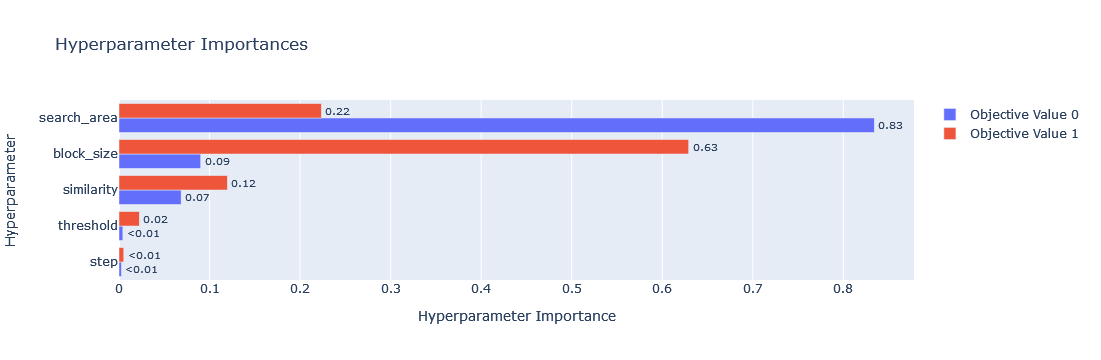

In [41]:
# Had a few false starts => removed first 15 trials
cleaned_trials = [trial for trial in study.trials if trial.number >= 15]
cleaned_study = optuna.create_study(directions=["minimize", "minimize"])
for trial in cleaned_trials:
    cleaned_study.add_trial(trial)

print(study.best_trials)
optuna.visualization.plot_param_importances(cleaned_study)

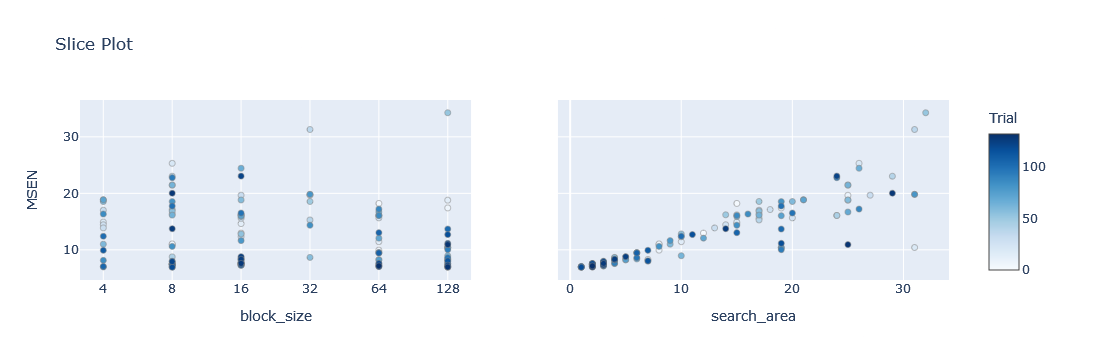

In [15]:
optuna.visualization.plot_slice(cleaned_study, params=["block_size","search_area"], target=lambda t: t.values[0], target_name='MSEN')

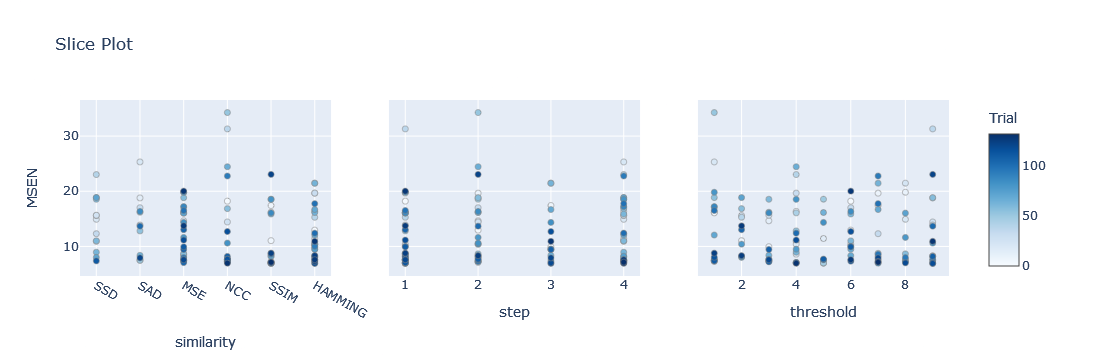

In [16]:
optuna.visualization.plot_slice(cleaned_study, params=["step", "similarity", "threshold"], target=lambda t: t.values[0], target_name='MSEN')

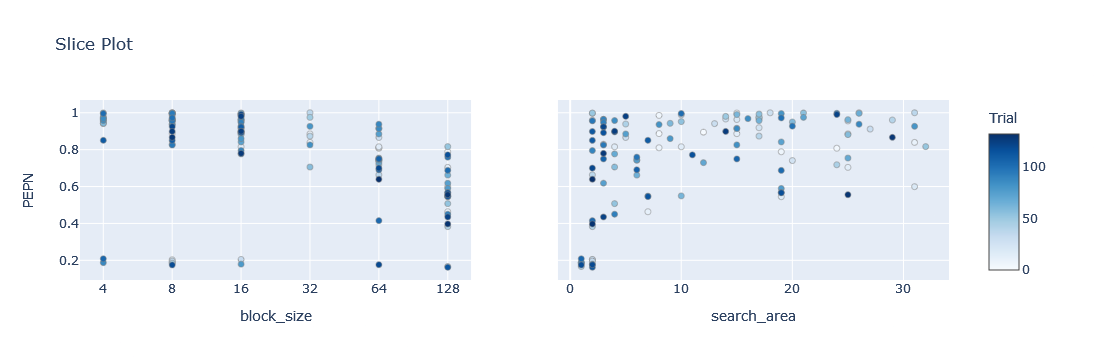

In [17]:
optuna.visualization.plot_slice(cleaned_study, params=["block_size","search_area"], target=lambda t: t.values[1], target_name='PEPN')

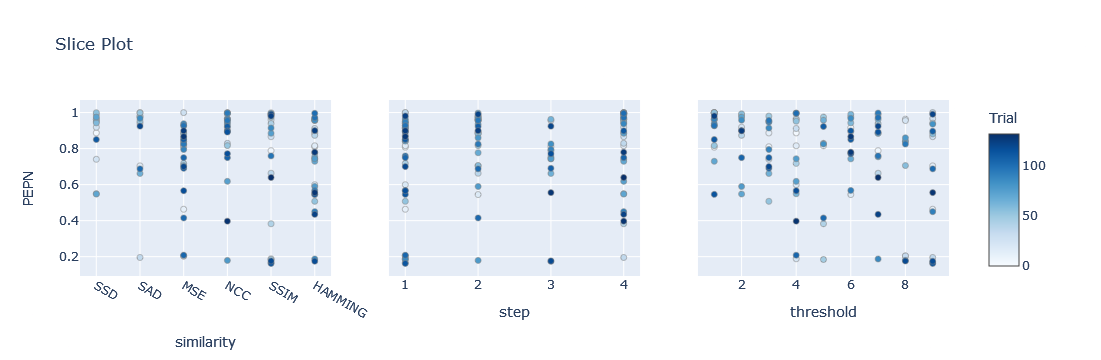

In [18]:
optuna.visualization.plot_slice(cleaned_study, params=["step", "similarity", "threshold"], target=lambda t: t.values[1], target_name='PEPN')

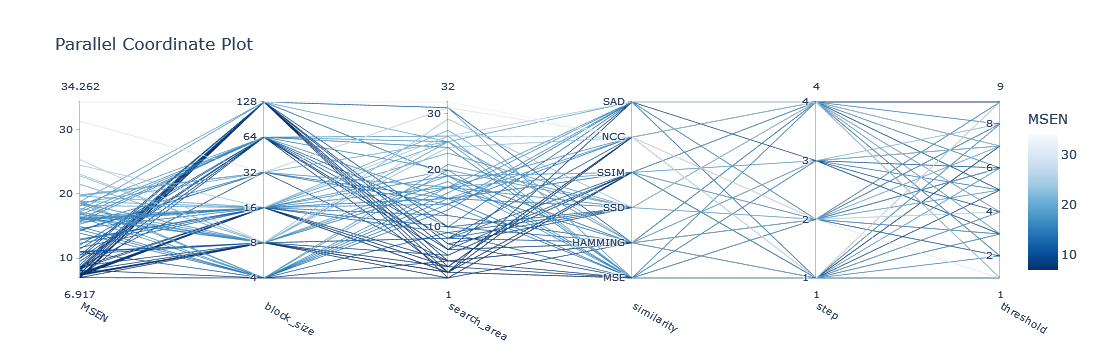

In [70]:
optuna.visualization.plot_parallel_coordinate(cleaned_study, params=["block_size","search_area","step","similarity","threshold"], target=lambda t: t.values[0], target_name='MSEN')

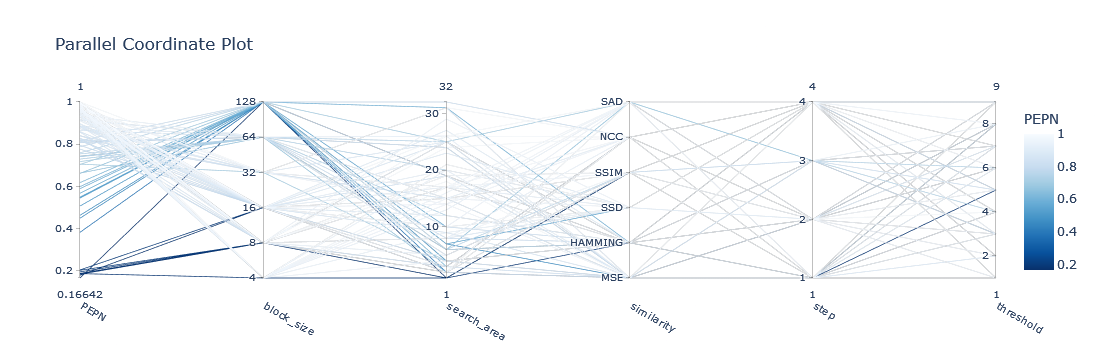

In [57]:
optuna.visualization.plot_parallel_coordinate(cleaned_study, params=["block_size","search_area","step","similarity","threshold"], target=lambda t: t.values[1], target_name='PEPN')

In [44]:
f = open('./summary.txt', 'a')
for trial in study.trials:
    f.write(f"\n Trial #{trial.number}: time: {(trial.datetime_complete - trial.datetime_start).seconds}, SCORE: {trial.values} \n\t {trial.params}\n")
f.close()